# Figure 7 MACM correspondence to cerebral and subcortical parcellations.

## We show how the meta-analytic conenctivity modeling (MACM) results correspond to subcortical areas (Tian et al. 2020), and to cerebral parcellations (Ji et al. 2019 for functional, Sancha-Velasco et al. 2023 for structural)

### Author: Neville Magielse
#### Date: 15.08.2024

In [1]:
import os
import sys

# User-specified base working directory
BASE_DIR = '/data/project/cerebellum_ale/'  # Change this to your project folder. Make sure they have input and output folders.

# Defines input and output paths.
INPUT_DIR = os.path.join(BASE_DIR, 'input')
OUTPUT_DIR = os.path.join(BASE_DIR, 'output')

sys.path.append(os.path.join(BASE_DIR, 'scripts'))

In [6]:
# Imports
import pandas as pd
import nibabel
import nilearn
import nilearn.plotting, nilearn.maskers, nilearn.image
import nilearn.surface
import numpy as np

from pprint import pprint
import itertools
import scipy
import scipy.spatial
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import nimare
from nimare.meta.cbma.ale import ALE, SCALE
from nimare.utils import vox2mm, mm2vox
from nimare_gpu.ale import DeviceALE, DeviceSCALE, DeviceMixin
from nimare.correct import FWECorrector

import argparse
from numba import cuda
import json
import glob


import warnings
warnings.simplefilter('ignore')

import neuromaps
import neuromaps.nulls

In [2]:
# Only list valid Domains (N >15 in ../output/macm_exp_stats_from_json_240814.csv)
domains = ['Action']

In [3]:
# Only list valid Subdomains (N >15 in ../output/macm_exp_stats_from_json_240814.csv)
subdomains = ['Execution', 'Execution.Speech', 'Memory.Working', 'Vision']


In [4]:
subdomains_exps = {'Execution': 251,
                   'Execution.Speech': 80, 
                   'Memory.Working': 21,
                   'Vision': 34}

In [7]:
subdomain_labels = pd.Series({
    'Action': 'Action',
    'Action.Execution': 'Execution',
    'Action.Execution.Speech': 'Speech Execution',
    'Cognition.Memory.Working': 'Working Memory',
    'Perception.Vision': 'Vision'
})

# Start with the subcortical comparison

# Load Tian et al. (2020) subcortical parcellation
## And resample it to the mask of the MACM data

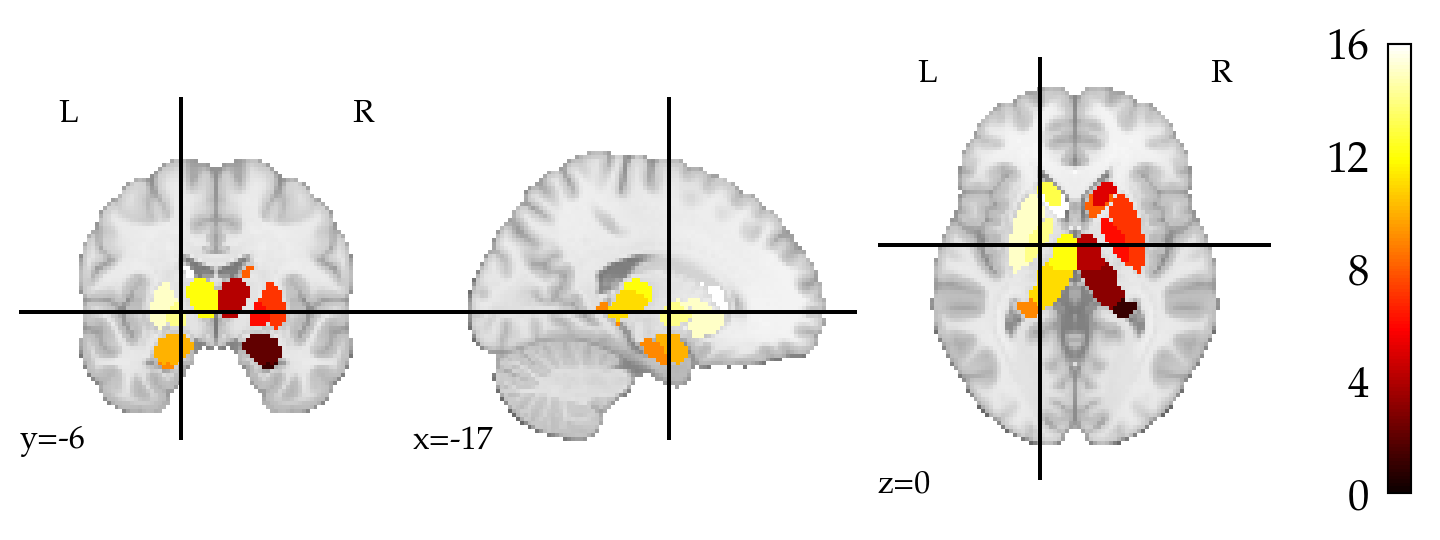

In [72]:
tian = nibabel.load(os.path.join(INPUT_DIR,'maps/Tian_Subcortex_S1_3T.nii'))
mask = nibabel.load(os.path.join(INPUT_DIR, 'maps/Grey10.nii.gz'))
tian_2mm = nilearn.image.resample_to_img(tian, mask)
nilearn.plotting.plot_stat_map(tian_2mm)

In [73]:
counts = pd.DataFrame({
    'macm': macm_bin.get_fdata().flatten(),
    'tian': tian_2mm.get_fdata().flatten() 
}).groupby('macm')['tian'].value_counts(sort=False)[(1, slice(None))]
counts

tian
0.0     71132
1.0       438
2.0       143
3.0       213
4.0       522
5.0        51
6.0        37
7.0       749
8.0       204
9.0       256
10.0      188
11.0      153
12.0      375
13.0       35
14.0       37
15.0      564
16.0      173
Name: count, dtype: int64

# Loop over domains

In [74]:
counts = {}

for macm_path in tqdm(sorted(glob.glob(
    '/data/project/cerebellum_ale/output/SALE/*/*/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz'
))):
    # todo: use re
    subbd = (macm_path
             .split('/corr_cluster_h-001_k-50_mask-D2009_MNI_z_macm/corr_cluster_k-50_z.nii.gz')[0]
             .split('/data/project/cerebellum_ale/output/SALE/')[1]
             .split('/')[1]
            )
    # binarize
    macm_bin = nilearn.image.binarize_img(macm_path)
    # counts
    counts[subbd] = pd.DataFrame({
        'macm': macm_bin.get_fdata().flatten(),
        'tian': tian_2mm.get_fdata().flatten() 
    }).groupby('macm')['tian'].value_counts(sort=False)[(1, slice(None))]

counts = pd.DataFrame(counts).sort_index()

# Define the list of valid subdomains
valid_MACMs = ['Action', 'Action.Execution', 'Action.Execution.Speech', 'Cognition.Memory.Working', 'Perception.Vision']

# Filter the counts DataFrame to only keep the columns in the valid subdomains list
counts = counts.loc[:, counts.columns.intersection(valid_MACMs)]

# Display the filtered DataFrame
counts

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.25it/s]


,Action.Execution.Speech,Action.Execution,Action,Cognition.Memory.Working,Perception.Vision
tian,,,,,
0.0,3792.0,8151,7735,806.0,1302.0
3.0,NaN,30,26,NaN,NaN
4.0,NaN,88,66,NaN,NaN
6.0,5.0,2,1,NaN,NaN
7.0,81.0,61,65,NaN,NaN
11.0,56.0,177,177,NaN,NaN
12.0,65.0,124,130,NaN,NaN
14.0,11.0,3,1,NaN,NaN
15.0,55.0,213,208,NaN,NaN


9 rows (Tian Parcels + background) x 5 colums (Valid MACM analyses)..
Drop anything non-subcortical (0.0) and calculate percentages.

In [75]:
counts_sctx = counts.drop(index=0.0).fillna(0)

In [76]:
pct = (counts_sctx / counts_sctx.values.sum(axis=0, keepdims=True)) * 100
# drop NaNs (no subcortical voxels in MACM)
pct = pct.dropna(axis=1)

In [77]:
labels = np.loadtxt(os.path.join(INPUT_DIR,
    'maps/Tian_Subcortex_S1_3T_label.txt'),
    dtype=str
)
labels

array(['HIP-rh', 'AMY-rh', 'pTHA-rh', 'aTHA-rh', 'NAc-rh', 'GP-rh',
       'PUT-rh', 'CAU-rh', 'HIP-lh', 'AMY-lh', 'pTHA-lh', 'aTHA-lh',
       'NAc-lh', 'GP-lh', 'PUT-lh', 'CAU-lh'], dtype='<U7')

In [78]:
import itertools
labels_clean = [
    f'{h} {struct}' for h, struct in \
    itertools.product(
        ['R', 'L'],
        ['Hippocampus',
         'Amygdala',
         'Posterior Thalamus',
         'Anterior Thalamus',
         'Nucleus Accumbens',
         'Globus Pallidum',
         'Putamen',
         'Caudate']
    )
]
labels_clean

['R Hippocampus',
 'R Amygdala',
 'R Posterior Thalamus',
 'R Anterior Thalamus',
 'R Nucleus Accumbens',
 'R Globus Pallidum',
 'R Putamen',
 'R Caudate',
 'L Hippocampus',
 'L Amygdala',
 'L Posterior Thalamus',
 'L Anterior Thalamus',
 'L Nucleus Accumbens',
 'L Globus Pallidum',
 'L Putamen',
 'L Caudate']

In [79]:
pct

,Action.Execution.Speech,Action.Execution,Action
tian,,,
3.0,0.000000,4.297994,3.857567
4.0,0.000000,12.607450,9.792285
6.0,1.831502,0.286533,0.148368
7.0,29.670330,8.739255,9.643917
11.0,20.512821,25.358166,26.261128
12.0,23.809524,17.765043,19.287834
14.0,4.029304,0.429799,0.148368
15.0,20.146520,30.515759,30.860534


In [80]:
pct_full = (
    pd.concat([
        pct,
        pd.Series(np.arange(1, 17)).rename('index')
    ], axis=1)
    .set_index('index')
    .sort_index()
    .fillna(0)
)

In [81]:
pct_full

,Action.Execution.Speech,Action.Execution,Action
index,,,
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,4.297994,3.857567
5,0.000000,12.607450,9.792285
6,0.000000,0.000000,0.000000
7,1.831502,0.286533,0.148368
8,29.670330,8.739255,9.643917
9,0.000000,0.000000,0.000000


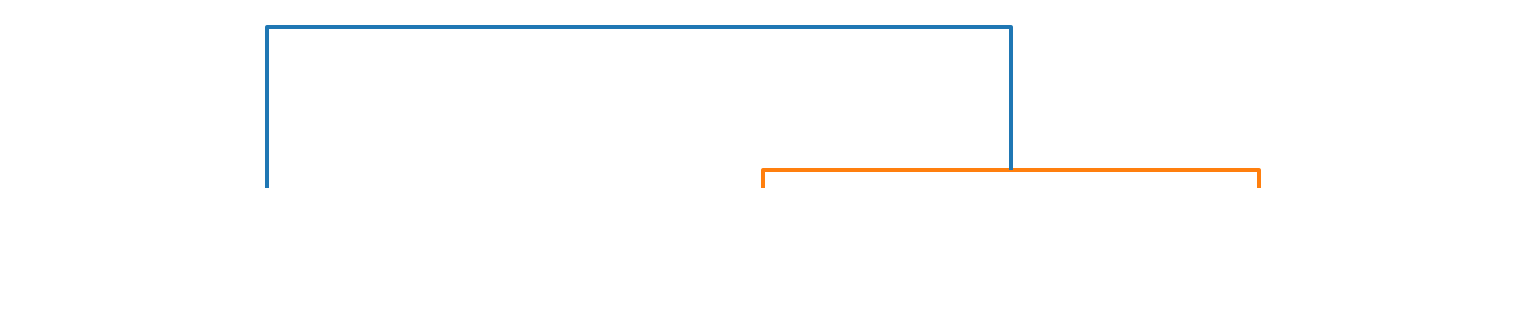

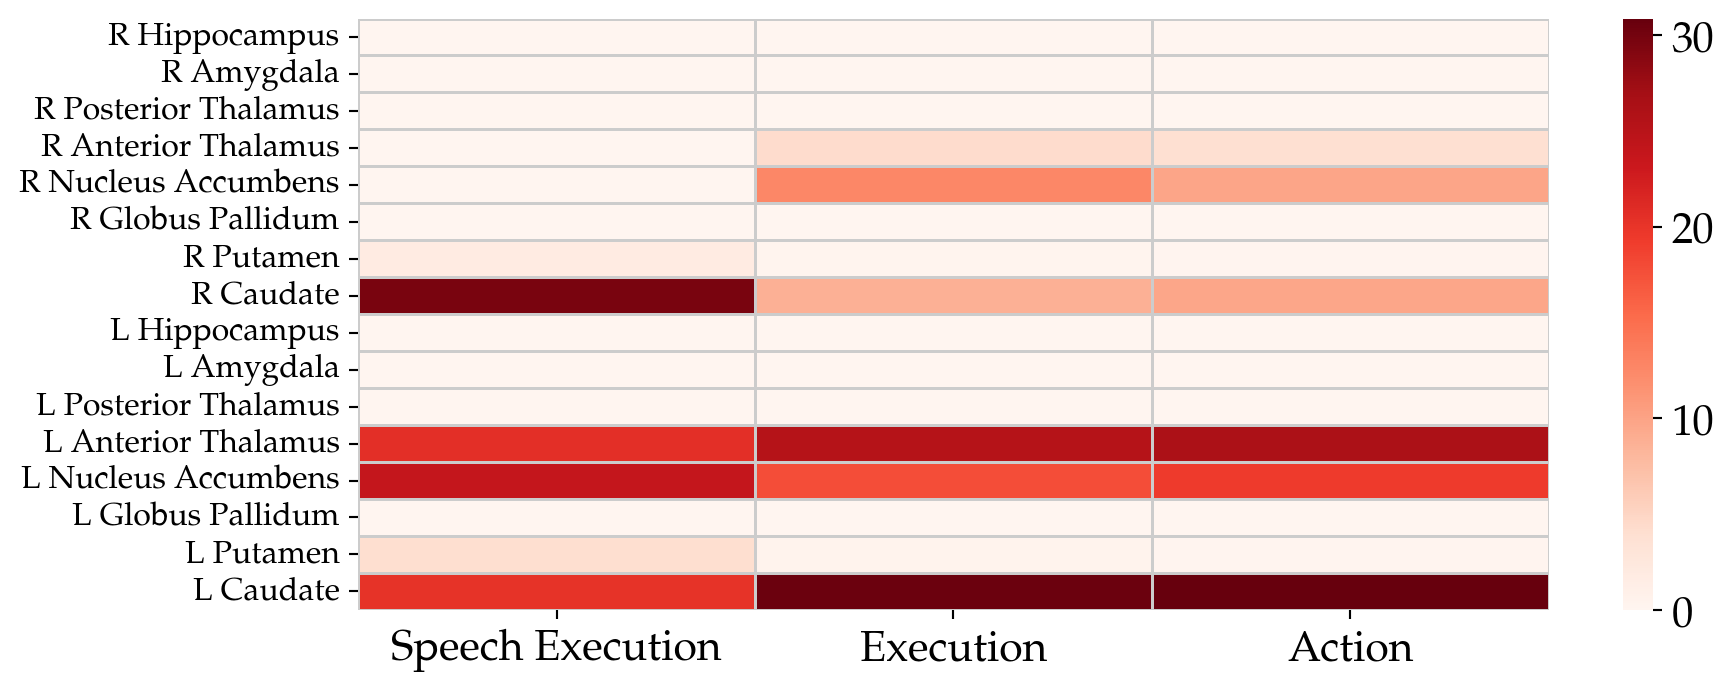

In [89]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# hierarchical clustering
model = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
model.fit(pct.T)

def create_linkage_matrix(model):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)

    for i, (left_child, right_child) in enumerate(model.children_):
        count_left = 1 if left_child < n_samples else counts[left_child - n_samples]
        count_right = 1 if right_child < n_samples else counts[right_child - n_samples]
        counts[i] = count_left + count_right

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    return linkage_matrix

# linkage matrix
linkage_matrix = create_linkage_matrix(model)

# plot the dendrogram and extract the leaf order
fig, ax = plt.subplots(figsize=(10, 2))
dendro = dendrogram(linkage_matrix, show_contracted=True, ax=ax, no_labels=True)
# ax.set_title("Hierarchical Clustering Dendrogram")
# ax.set_ylabel("Distance")
ax.set_ylim([-25, ax.get_ylim()[1]])
ax.axis('off')

# Save the dendrogram to file
plt.savefig(os.path.join(BASE_DIR, 'Figures/Publication/Figure7/Tian2022_percentage_dendrogram.png'), bbox_inches='tight', dpi=300)


# extract the ordering
leaf_order = dendro['leaves']

# reorder the original data
pct_reordered = pct_full.iloc[:, leaf_order]

# plot the reordered data
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(pct_reordered, cmap='Reds', linewidths=1, linecolor='.8', ax=ax)
ax.set_xticklabels(subdomain_labels.loc[pct_reordered.columns], rotation=0, horizontalalignment='center')
ax.set_yticks(np.arange(len(labels_clean))+0.5)
ax.set_yticklabels(labels_clean, rotation=0, fontsize=12)
ax.set_ylabel('')

# Save the heatma0 to file
plt.savefig(os.path.join(BASE_DIR, 'Figures/Publication/Figure7/Tian2022_percentage_heatmap.png'), bbox_inches='tight', dpi=300)